<a href="https://colab.research.google.com/github/lazarovps/Data-Science/blob/main/Santander_Customer_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Santander Customer Satisfaction - Previsão de Churn

Um dos problemas enfrentados por empresas que oferecem serviços com cobrança periodíca é o cancelamento do serviço, conhecido com "churn", que afeta a capacidade de faturamento da empresa no curto e longo prazo. 
Com base nisso, é desejável para qualquer empresa prever quem são os clientes mais propensos à churn, para que possa tentar entender a dor desse cliente e se possível fazê-lo ficar, evitando assim a perda de receita.

Esse trabalho pretende, através de Machine Learning, prever quais são os possíveis clientes que irão "churnar" com a empresa em um período próximo.
Esse case foi baseado no desafio posto no Kaggle pelo Banco Santander para a identificação dos clientes insatisfeitos.

#Importação das bibliotecas principais e dos dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive 
warnings.filterwarnings("ignore")
drive.mount('/content/drive')
%cd /content/drive/My Drive/Python


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Python


In [2]:
train = pd.read_csv('train_santander.csv')

#Análise exploratória e manipulação dos dados

In [3]:
train.shape
#A base de dados (dataset) possui 76 mil linhas e 371 colunas

(76020, 371)

In [4]:
#visualização das 3 primeiras linhas do dataset
train.head(3)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [5]:
#Separação da variável alvo (TARGET) das variáveis preditoras
y_train = train[['TARGET']]
train = train.drop('TARGET', axis = 1)

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace2,76020.0,31.505324,2013.125393,0.00,0.0000,0.00,0.0000,438329.22
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30


Ao verificar as estatísticas descritivas das variáveis, percebe-se que a variável "var3" está com valores mínimos de -999999, o que provavelmente representa valores nulos, para evitar problemas nos modelos, iremos substituir todos os valores que estiverem assim por 0, diminuindo o impacto desses no resultado final.

Além disso, iremos remover a coluna 'ID', já que essa é apenas uma forma de identificação de cada indivíduo.

In [7]:
train = train.replace(-999999,0)
train = train.drop('ID', axis = 1)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 369 entries, var3 to var38
dtypes: float64(111), int64(258)
memory usage: 214.0 MB


Ao olharmos o dtype, percebemos que há 111 variáveis do tipo flutuantes e 258 do tipo inteiro. Portanto, não temos a necessidade de fazer transformação de variáveis categóricas.

In [9]:
y_train

,TARGET
0,0
1,0
2,0
3,0
4,0
...,...
76015,0
76016,0
76017,0
76018,0


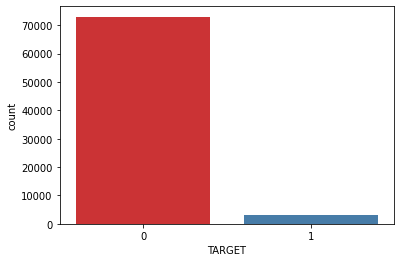

In [10]:
sns.countplot( x= 'TARGET', data = y_train, palette = 'Set1')

In [11]:
y_train['TARGET'].value_counts(normalize = True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [12]:
y_train['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

Verificando a distribuição da variável alvo percebemos que o dataset está muito desbalanceado, com indivíduos que não deram churn em 96% dos dados, nesses casos, antes de modelarmos, é extremamente necessário deixar os dados balanceados, para que o nosso modelo não tenda à prever de maneira equivocada.

Para balancear os dados, iremos utilizar a técnica Synthetic Minority Oversampling Technique (SMOTE), que gera nova instâncias de dados a partir da proximidade das variáveis de dados semelhantes. Essa técnica está presente no pacote imblearn.

O único argumento que iremos utilizar é o "sampling_strategy" que representa a razão que queremos da classe minoritária sobre a classe majoritária, escolhendo a razão de 0.50, significa que a quantidade de exemplos da classe minoritária será 50% da classe majoritária (atualmente esse valor é de 4 %)



In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.50)

In [14]:
x_train, y_train = smote.fit_resample(train,y_train)

In [15]:
x_train.shape, y_train.shape

((109518, 369), (109518,))

Percebemos que agora nosso dataset possui mais de 109 mil observações, ou seja, geramos 33 mil "individuos sinteticos", todos com a variável alvo igual a 1. Agora, temos 36 mil que "churnaram" contra 73 mil que não "churnaram"

In [16]:
y_train.sum()

36506

Além desse procedimento, podemos eliminar alguns dados da classe majoritária. Esse método não é muito indicado quando há poucos dados, já que estaremos perdendo informação, mas nesse caso é aplicável. A forma que vamos eliminar os exemplos será aleatória, com o Random Under Sampler, também do imblearn.

In [17]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy = 0.90, random_state = 12)

Para preservar o máximo de informação possível, podemos fazer com que a classe minoritária seja 90% da classe majoritária, essa diferença não prejudicará os resultados do modelo.

In [18]:
x_train,y_train = rus.fit_resample(x_train,y_train)

In [19]:
x_train.shape

(77068, 369)

Agora possuimos 77 mil individuos, mas dessa vez as classes estão quase qu perfeitamente balanceadas.

Após isso, podemos dividir entre dados em treino e validação, onde o conjunto de treino serve para o algoritmo aprender os padrões das variáveis e o conjunto de validação, como o nome sugere, serve para avaliarmos se o algoritmo "aprendeu bem". 

A divisão será em 70% dados de treino e 30% dados de validação.

In [20]:
from sklearn.model_selection import train_test_split as tts
x_train, x_valid, y_train, y_valid = tts(x_train,y_train, test_size = 0.30, random_state = 12)

In [21]:
x_train.shape, x_valid.shape

((53947, 369), (23121, 369))

In [22]:
y_train.shape, y_valid.shape

((53947,), (23121,))

Após a divisão, iremos padronizar as variáveis, deixando todas na mesma escala, já que a escala inapropriada das variáveis acaba afetando negativamente os resultados de muitos algoritmos de Machine Learning.

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

#Seleção das variáveis

Após a padronização podemos começar o processo de seleção das variáveis, por possuir mais de 360, é provável que muitas dessas sejam bastante correlacionadas, o que também prejudica o aprendizado da máquina, para evitar isso podemos fazer uma seleção das melhores variáveis de acordo com algum critério.

O método que foi pensado para essa seleção será o Principal Components Analysis(PCA), basicamente, ele procura reduzir a dimensionalidade de um conjunto de dados mantendo a maior quantidade de informação (variância dos dados) possível. 



In [25]:
from sklearn.decomposition import PCA
pca = PCA()

In [26]:
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Ao fitarmos o algoritmo, teremos um valor para cada uma das dimensões, esse valor representa o quanto aquela dimensão explica a variância do conjunto de dados, então, queremos manter as dimensões que mais explicam a variância. o método "explained_variance_ratio_" ordena esses valores do maior para menor, e sua soma será 1 (ou 100%).

In [27]:
pca.explained_variance_ratio_

array([9.35588655e-02, 5.28809617e-02, 4.07535519e-02, 3.68942818e-02,
       3.62399225e-02, 3.53587911e-02, 3.20670909e-02, 3.14342677e-02,
       2.88217397e-02, 2.77829234e-02, 2.47108114e-02, 2.33295680e-02,
       2.16500230e-02, 2.06348341e-02, 1.69014688e-02, 1.56170739e-02,
       1.44673537e-02, 1.36254043e-02, 1.32379534e-02, 1.31109716e-02,
       1.28261584e-02, 1.23551548e-02, 1.23056977e-02, 1.19489867e-02,
       1.11845031e-02, 1.10323208e-02, 1.02276314e-02, 1.01732678e-02,
       9.94456268e-03, 9.65964660e-03, 9.35362281e-03, 9.10623929e-03,
       9.02246945e-03, 8.81232176e-03, 8.66635675e-03, 7.96674334e-03,
       7.19013777e-03, 6.91602337e-03, 6.81838490e-03, 6.65558990e-03,
       6.62681035e-03, 6.36196975e-03, 6.14449836e-03, 5.91180383e-03,
       5.85503049e-03, 5.67688971e-03, 5.59795575e-03, 5.18409360e-03,
       5.10058220e-03, 4.84611938e-03, 4.71374019e-03, 4.55959928e-03,
       4.46638181e-03, 4.38190199e-03, 4.18000396e-03, 3.88773996e-03,
      

In [28]:
np.sum(pca.explained_variance_ratio_)

0.9999999999999999

Para uma melhor intuição, podemos plotar o "poder explicativo" das 10 principais dimensões (ou componentes)

In [29]:
var_pca = pca.explained_variance_ratio_

In [30]:
first_10 = np.arange(1,11)

Text(0, 0.5, 'Razão da variância explicada')

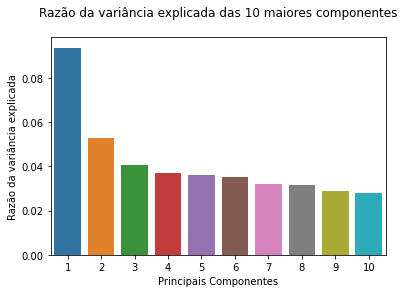

In [31]:
sns.barplot(x = first_10, y = var_pca[0:10])
plt.title("Razão da variância explicada das 10 maiores componentes\n")
plt.xlabel("Principais Componentes")
plt.ylabel("Razão da variância explicada")

Com isso vemos que a componente 1 explica aproximadamente 9% da variância dos dados, a componente 2 explica 5 % e assim sucessivamente. O objetivo então, é manter o mínimo de componentes possível mas mantendo boa parte da explicação da variância

In [32]:
pc = np.arange(10,210,10)

In [33]:
for i in pc:
  print("Com as {} maiores componentes, capta-se cerca de {} % da variância dos dados".format(i,np.round((var_pca[0:i].sum()*100),2)))

Com as 10 maiores componentes, capta-se cerca de 41.58 % da variância dos dados
Com as 20 maiores componentes, capta-se cerca de 59.31 % da variância dos dados
Com as 30 maiores componentes, capta-se cerca de 70.47 % da variância dos dados
Com as 40 maiores componentes, capta-se cerca de 78.52 % da variância dos dados
Com as 50 maiores componentes, capta-se cerca de 84.25 % da variância dos dados
Com as 60 maiores componentes, capta-se cerca de 88.31 % da variância dos dados
Com as 70 maiores componentes, capta-se cerca de 91.3 % da variância dos dados
Com as 80 maiores componentes, capta-se cerca de 93.66 % da variância dos dados
Com as 90 maiores componentes, capta-se cerca de 95.49 % da variância dos dados
Com as 100 maiores componentes, capta-se cerca de 96.8 % da variância dos dados
Com as 110 maiores componentes, capta-se cerca de 97.77 % da variância dos dados
Com as 120 maiores componentes, capta-se cerca de 98.48 % da variância dos dados
Com as 130 maiores componentes, capta-s

Percebemos que o retorno marginal de 10 componentes a mais é cada vez menor, a fim de simplificar o máximo o conjunto de dados, podemos deixar apenas as 100 maiores componentes, que explicam aproximadamente 97% da variância dos dados.

Então novamente fitamos o PCA, mas escolhendo 100 no argumento "n_components", dessa forma, todos os nossos dados serão representados em apenas 100 dimensões (tínhamos aproxidamente 370)

In [34]:
pca = PCA(n_components=100)

In [35]:
x_pca_train = pca.fit_transform(x_train_scaled)
x_pca_valid = pca.transform(x_valid_scaled)

In [36]:
x_pca_train.shape, x_pca_valid.shape

((53947, 100), (23121, 100))

In [37]:
x_pca_train

array([[-2.62197823e+00, -1.27542195e+00,  1.81145379e-01, ...,
        -2.96580777e-02,  9.62482379e-03, -6.02559378e-02],
       [-2.57074433e+00, -1.24322105e+00,  1.80554242e-01, ...,
        -1.58888836e-01, -1.35440576e-01,  6.48386604e-02],
       [-2.61930427e+00, -1.26578516e+00,  1.79127338e-01, ...,
        -3.74122449e-02,  1.98472968e-02, -4.30906553e-02],
       ...,
       [-1.72354096e+00, -3.96442415e-01,  4.46661343e-02, ...,
         4.64074275e-01, -2.95808446e-02,  2.94374553e-01],
       [-3.20819245e+00, -1.66590610e+00,  3.61546606e-01, ...,
        -4.25371341e-02,  1.51626459e-02, -8.03507168e-02],
       [-2.52231148e+00, -1.13513366e+00,  1.71116062e-01, ...,
         3.85537721e-04,  1.34705971e-01, -1.89806429e-02]])

Um ponto negativo da redução de dimensionalidade é que as variáveis restantes não posssuem mais interpretação lógica.

Após todo esse processo, podemos enfim tentar prever o Churn. Os modelos que serão utilizados são a Regressão Logística e a Random Forest Classifier.

#Modelo 1 - Regressão Logística

In [38]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

In [39]:
log.fit(x_pca_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_predict_log = log.predict(x_pca_valid)

Ao fitarmos e prevermos os valores para os dados de validação, devemos escolher por qual métrica iremos olhar o resultado. As que serão utilizadas nesse caso serão:

Precisão (Precision score) - pode ser entendida como a pergunta "Dos exemplos que foram classificados como positivo (Churn), quantos realmente são?"

Revocação (Recall score) - Pode ser entendida pela pergunta "Dos exemplos positivos (Churn), quantos foram previstos?"

F1 (F1 score) - essa métrica é uma ponderação das anteriores, ela é especificamente definida como 2 * ((precisão * revocação)/(precisão + revocação))

Todas essas métricas estão no intervalo entre 0 e 1, onde 0 indica que nosso modelo não acerta nenhuma previsão e 1 (100%) que ele acerta todas. No fim, desejamos um valor suficiente próximo de 1.



In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [42]:
precision_log = precision_score(y_valid,y_predict_log)
recall_log = recall_score(y_valid,y_predict_log)
f1_log = f1_score(y_valid,y_predict_log)

#Modelo 2 - Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [44]:
rfc.fit(x_pca_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
y_predict_rfc = rfc.predict(x_pca_valid)

In [46]:
precision_rfc = precision_score(y_valid,y_predict_rfc)
recall_rfc = recall_score(y_valid,y_predict_rfc)
f1_rfc = f1_score(y_valid,y_predict_rfc)

#Resultados

Enfim, podemos comparar o resultado dos 2 modelos:

In [47]:
print("Resultados da Regressão Logística\n")
print("Precision score:{}".format(precision_log))
print("Recall score:{}".format(recall_log))
print("F1 score:{}\n".format(f1_log))

print("Resultados da Random Forest\n")
print("Precision score:{}".format(precision_rfc))
print("Recall score:{}".format(recall_rfc))
print("F1 score:{}".format(f1_rfc))

Resultados da Regressão Logística

Precision score:0.6984262016163335
Recall score:0.7475188928343804
F1 score:0.7221391503210485

Resultados da Random Forest

Precision score:0.9194369849060098
Recall score:0.9040335063279614
F1 score:0.9116701863924341


Em todas as métricas observadas, os valores do algoritmo de Random Forest é maior que o de Regressão Logística, sugerindo que esse primeiro possui um maior poder preditivo.

Finalmente iremos prever o Churn para os clientes dos dados de teste.

Então, devemos transformar os dados da forma que fizemos com os dados de treino e de validação:

In [48]:
#Leitura dos dados
x_test = pd.read_csv('test_santander.csv')

#Substituição dos dados "nulos" por 0 e remoção da coluna 'ID
x_test = x_test.replace(-999999,0)
x_test = x_test.drop('ID', axis = 1)

#Padronização e seleção das variáveis
x_test_scaled = scaler.transform(x_test)
x_pca_test = pca.transform(x_test_scaled)

In [49]:
#Predição
y_test_predict = rfc.predict(x_pca_test)

In [50]:
y_test_predict.shape

(75818,)

In [51]:
y_test_predict.sum()

6006

Pelo fato de não termos os reais resultados para os dados de teste, não temos como utilizar as métricas definidas anteriormente para o avaliarmos, mas, esperamos que os resultados sejam semelhantes aos dados de validação. Podemos observar que dos aproximadamente 76 mil valores previstos, 6 mil foram previstos como clientes de potencial Churn, ficando à cargo do setor de Marketing, a tentativa de evitar isso.